## 权重衰退
一种常见的**处理过拟合**的**正则化技术**之一，常被称为$L2$正则化——岭回归  
- 过拟合总是可以通过**收集更多的训练数据**来缓解，但是成本高，耗时多
- **限制特征的数量**是缓解过拟合的一种常用技术，到那时简单的求其特征过于生硬

### 使用均方范数作为**硬性**限制
通过限制参数值的选择范围来控制模型容量
$$
\min \ell(w, b) \quad \text{使得} \quad \|w\|^2 \leq \theta
$$
- 通常**不限制**偏移$b$
- **小**的$\theta$意味着**更强**的正则项

### 使用均方范数作为**柔性**限制
对每个$\theta$，都可以找到$\lambda$使得之前的目标函数等价于
$$
\min \ell(w, b) + \frac{\lambda}{2} \|w\|^2
$$
可以通过拉格朗日乘子来证明
- 超参数$\lambda$控制了正则项的重要程度  
$\lambda = 0$，无作用  
$\lambda \to \infty, \quad w^* \to 0$

### 参数更新法则
- 计算梯度  
$$
\frac{\partial}{\partial w} \left( \ell(w, b) + \frac{\lambda}{2} \|w\|^2 \right) = \frac{\partial \ell(w, b)}{\partial w} + \lambda w
$$

- 时间$t$更新参数  
$$
w_{t+1} = (1 - \eta \lambda) w_t - \eta \frac{\partial \ell(w_t, b_t)}{\partial w_t}
$$

通常$\eta \lambda < 1$，在深度学习中通话吃那个叫做**权重衰退**

### 总结
- 权重衰退通过$L2$正则项使得**模型参数不会过大**，从而控制模型复杂度
- 正则项权重是控制模型复杂度的**超参数**

## 高维线性回归
**演示**权重衰减

In [1]:
%matplotlib inline
import torch

from torch import nn
from d2l import torch as d2l

生成一些数据集
$$
y = 0.05 + \sum_{i=1}^{d} 0.01 x_i + \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, 0.01^2).
$$
为使得**过拟合效果更加明显**，可以将问题的维数增加到$d=200$，并使用一个只包含20个样本的小训练集

In [18]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train) # 生成y = Xw + b + 噪声
train_iter = d2l.load_array(train_data, batch_size)      # 构造一个pytorch数据迭代器

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False) 

## 从0开始实现
从头开始实现权重衰减，只需将$L2$的平方惩罚添加到原始目标函数中

### 初始化模型参数

In [14]:
def init_param():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2函数惩罚

In [9]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2
  # return torch.matmul(w, w) / 2

### 定义训练代码实现
唯一的变化是包含了**惩罚项**
- `torch.norm(w)`，计算张量`w`的范数
- `.item()`将一个标量张量转换为一个Python数值

In [16]:
def train(lambd):
    w, b = init_param()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)   # 进行小批量梯度下降
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('w的l2范数是：', torch.norm(w).item())

### 忽略正则化直接训练
- 明显**过拟合**

w的l2范数是： 13.01168441772461


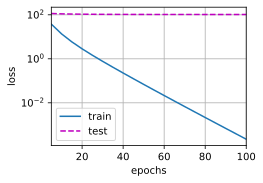

In [19]:
train(lambd=0)

### 使用权重衰减
- 训练误差增加，但测试误差减小，正是期望从**正则化**中得到的效果
- 训练集过小，过拟合很难避免

w的l2范数是： 0.37452563643455505


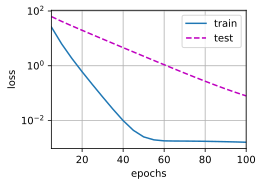

In [22]:
train(lambd=3)

w的l2范数是： 0.02035762369632721


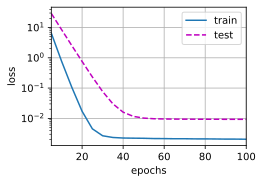

In [21]:
train(lambd=10)

### 简洁实现 
深度学习框架**将权重衰减集成到优化算法中**，以便**与任何损失函数结合使用**  
运行**更快**，更容易实现；对于更复杂的问题，会更加明显 
- 在实例化优化器时直接通过`weight_decay`指定weitht decay超参数
- `torch.optim.SGD`接收一个参数列表，定义了要优化的参数和对应的优化设置
- `param.data.normal_`：  
`data`属性访问张量的实际数据储存（一般用于**初始化**或**更新参数**）  
`normal_()`是一个**就地操作**方法，用标准正态分布的随机数初始化张量，改变张量本身

#### 过程：
- 模型定义
- 初始化权重`param.data.normal_()`
- 损失函数
- 优化器设置
- 训练循环

In [26]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {'params':net[0].weight, 'weight_decay':wd},
        {'params':net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()  # 先清空梯度
            l = loss(net(X), y) 
            l.mean().backward() 
            trainer.step()       # 更新参数
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, 
                        (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss))
                        )
    print('w的L2范数:', net[0].weight.norm().item())

w的L2范数: 13.616545677185059


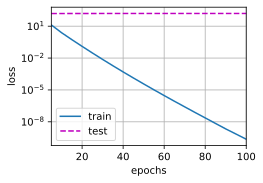

In [27]:
train_concise(0)

w的L2范数: 0.34099724888801575


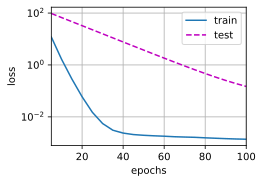

In [28]:
train_concise(3)

### 小结
- 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度
- 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
- 权重衰减功能在深度学习框架的**优化器**中提供
- 在同一训练代码实现中，不同的参数集可以有不同的更新行为

### 练习
1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数。观察到了什么？
1. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？
1. 如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。能找到类似的矩阵方程吗（见 :numref:`subsec_lin-algebra-norms` 中的Frobenius范数）？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想出其他什么方法来处理过拟合？
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？

### 回答
1. 随着$\lambda$增加，训练精度和测试精度逐渐靠近，但是最终没有靠在一起

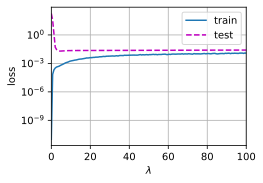

In [36]:
import torch
import numpy as np

from torch import nn

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

net = nn.Sequential(nn.Linear(num_inputs, 1))
loss = nn.MSELoss(reduction='none')

def train_wd(wdlist, net, loss, train_iter, test_iter, layer=[0], num_epochs=100, lr=0.003):
    animator = d2l.Animator(xlabel='$\lambda$', ylabel='loss', yscale='log',
                           xlim=[wdlist[0], wdlist[-1]], legend=['train', 'test'])
    for param in net.parameters():
        param.data.normal_()
    for wd in wdlist:
        for i in layer:
            trainer = torch.optim.SGD([
                {'params':net[i].weight, 'weight_decay':wd},
                {'params':net[i].bias}
            ], lr=lr)
        for i in range(num_epochs):
            for X, y in train_iter:
                trainer.zero_grad()
                l = loss(net(X), y)
                l.mean().backward()
                trainer.step()
        animator.add(wd, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))

train_wd(np.linspace(0., 100., 150), net, loss, train_iter, test_iter)         

2. （验证集用于调整超参数，如$\lambda$）不一定会死最优解，因为仅仅是在验证集上表现最好  
找到一个接近最优的$\lambda$对于模型的泛化能力至关重要，即使$\lambda$不是全局最优，使用验证集来选择$\lambda$依然是正则化模型中最可靠的方法之一，可以显著减少过拟合（可以使用交叉验证）  
不一定是最优的解，但绝不是过拟合的解

3. 处理过拟合:
- 权重衰减（$L_2$正则化）  
- 增加训练数据  
- 使用适当复杂的模型  
- 数据增强：通过对训练数据进行各种转换，生成更多样化的数据  
- 交叉验证  
- Dropout正则化：在神经网络每一层训练过程中，随机丢弃一部分神经元及其连接，以减少神经元的相互依赖  
- 早停：在训练过程中，当验证集的误差不再下降时，提前停止训练  
- Batch Normalization(批量归一化)：在每一层网络的输入处对数据进行标准化  
- 简化模型（模型减枝、权重共享等）  
- 噪声注入  
- 改变模型框架：选择更合适的网络结构，如ResNet的残差网络结构代替普通的深度卷积网络

4. **学习贝叶斯部分，忘了妥了**
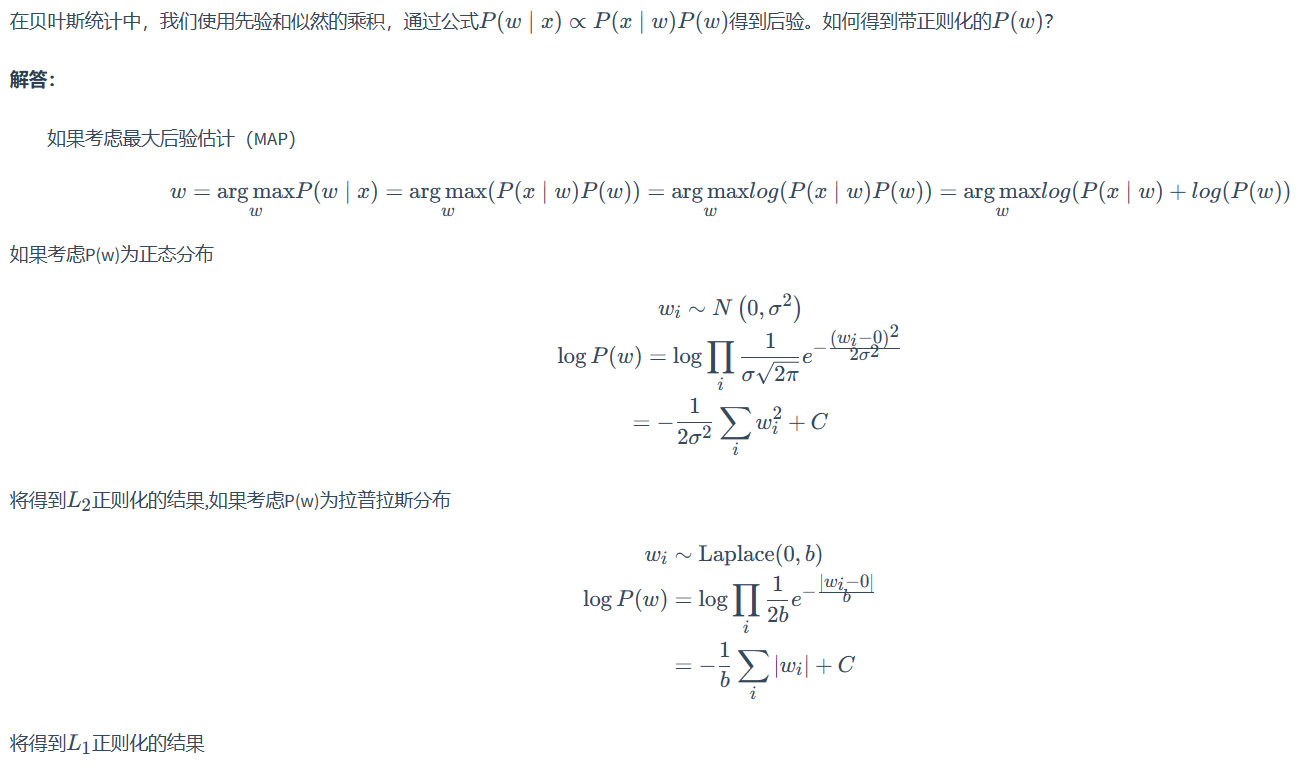

### Q&A
1. weight_decay的值一般怎么选:0.01，0.001，0.0001
- 一般的经验范围是：1e-5 到 1e-3 之间